In [8]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

In [9]:
import pandas as pd
import seaborn as sns; sns.set()
import warnings
import numpy as np
import logging
import sys
import time
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [10]:
# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt
import matplotlib.pyplot as plt

In [11]:
import torch
import random
random.seed(42)
np.random.seed(42)
rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [4]:
stock_twits_balanced = pd.read_csv('Data/StockTwits/StockTwits_Balance.csv', sep="\t")

In [5]:
stock_twits_balanced

,Unnamed: 0,org message,sentence,label
0,0,$AAPL looking for puts to pay,looking puts pay,0
1,1,$SPY Moves already happened. Retrace - CPR/Gap...,moves already happened retrace cpr gapfill sub...,1
2,2,$AMZN $AAPL $TSLA $AMD Jobs growth for July is...,jobs growth july seasonally higher jobs due su...,2
3,3,$AAPL i sold this pos 🩸🩸🩸🩸🩸🩸🩸🩸💩💩💩💩 $AMZN $MS...,sold pos,0
4,4,$AMZN $AAPL $SHIB.X $BTC.X $AMC is pouncing ha...,x x pouncing hard time comin,2
...,...,...,...,...
137178,137178,$AAPL tomorrow,tomorrow,0
137179,137179,"The death of FAANG has arrived, and we welcome...",death faang arrived welcome age maage,2
137180,137180,$TTD tomorrow is gonna be nasty (in a bad way)...,tomorrow gonna nasty bad way today earnings gu...,0
137181,137181,$AAPL you think 25 PE is realistic? Good years...,think pe realistic good years apple around,0


In [6]:
stock_twits_balanced = stock_twits_balanced.dropna().reset_index(drop=True)

<AxesSubplot:ylabel='Density'>

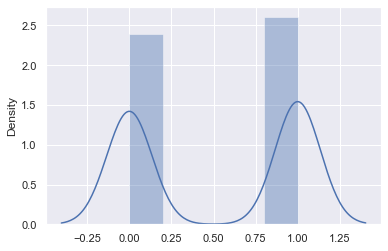

In [12]:
# Check the distribution to decide the maximum length
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sns.distplot([len(tokenizer.tokenize(text)) for text in str(stock_twits_balanced['sentence'])])

In [9]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        #  concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(dense_out)
        # out = self.fc(self.dropout(feature))

        return out

In [10]:
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
inputs = tokenizer("Hello, my cat is cute", 
                   return_tensors="pt", 
                   pad_to_max_length=True, 
                   max_length = 64,
                   add_special_tokens=True,
                   padding_side='right')
print('inputs: \n', inputs)
print('\ndecoded: \n',tokenizer.decode(inputs['input_ids'].squeeze(0)))

labels = torch.tensor([1]).unsqueeze(0)
print('\nlabels: ', labels)

outputs = bert_model(**inputs, labels=labels)
print('\noutputs: length=', len(outputs))
print(outputs)

loss = outputs[0]
logits = outputs[1]

print('loss: ', loss.detach())
print('logits: ', logits.detach())

print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs[0].detach())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

inputs: 
 {'input_ids': tensor([[  101,  7592,  1010,  2026,  4937,  2003, 10140,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [11]:
# Split the data
msk = np.random.rand(len(stock_twits_balanced)) < 0.8
train = stock_twits_balanced[msk]
test = stock_twits_balanced[~msk]

In [12]:
train

,Unnamed: 0,org message,sentence,label
0,0,$AAPL looking for puts to pay,looking puts pay,0
2,2,$AMZN $AAPL $TSLA $AMD Jobs growth for July is...,jobs growth july seasonally higher jobs due su...,2
3,3,$AAPL i sold this pos 🩸🩸🩸🩸🩸🩸🩸🩸💩💩💩💩 $AMZN $MS...,sold pos,0
4,4,$AMZN $AAPL $SHIB.X $BTC.X $AMC is pouncing ha...,x x pouncing hard time comin,2
5,6,Sweep Options Activity: $AAPL is the #3 ticker...,sweep options activity ticker sweep activity i...,1
...,...,...,...,...
130628,137177,$SPY from #jasperAlerts the $TSLA king. Pleasu...,jasperalerts king pleasure traders like us chats,1
130630,137179,"The death of FAANG has arrived, and we welcome...",death faang arrived welcome age maage,2
130631,137180,$TTD tomorrow is gonna be nasty (in a bad way)...,tomorrow gonna nasty bad way today earnings gu...,0
130632,137181,$AAPL you think 25 PE is realistic? Good years...,think pe realistic good years apple around,0


In [13]:
#out of memory required to run this for refresh memory
import torch
torch.cuda.empty_cache()


In [28]:
import gc
gc.collect()
torch.cuda.memory_summary(device="cuda:0", abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |    7369 MB |   11635 MB |   11635 MB |\n|       from large pool |       0 B  |    7366 MB |   11632 MB |   11632 MB |\n|       from small pool |       0 B  |       2 MB |       2 MB |       2 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |    7369 MB |   11635 MB |   11635 MB |\n|       from large pool |       0 B  |    7366 MB |

In [15]:
def train_transformer(model, x_train, y_train, x_valid, y_valid, learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length):
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # # Train Data in Tensor
    # train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    # train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    # train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    # train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # # Validation Data in Tensor
    # valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    # valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    # valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    # valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # # Load data into TensorDataset
    # train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    # valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Load data into SimpleDataset
    train_ds = SimpleDataset(x_train, y_train)
    valid_ds = SimpleDataset(x_valid, y_valid)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    print('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), num_epochs))
    
    # Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    # To reproduce BertAdam specific behavior set correct_bias=False
    optimizer = AdamW_HF(model.parameters(), lr=learning_rate, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    ## Set Loss Function
    ## If we use BertForSequenceClassification, Loss function is already included and no need to define.
    # Loss Function - use Cross Entropy as binary classification
    #loss_fn = torch.nn.CrossEntropyLoss()

    ## Set Optimizer
    ## Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    ## If we use torch.optim.Adam, set with parameter groups like this:
    # param_optimizer = list(model.named_parameters())
    # no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    # optimizer_grouped_parameters = [
    #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)

    # Set Train Mode
    model.train()
    
    # Tokenizer Parameter
    param_tk = {
        'return_tensors': "pt",
        'padding': 'max_length',
        'max_length': max_seq_length,
        'add_special_tokens': True,
        'truncation': True
    }

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((len(y_valid), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    for epoch in tqdm(range(num_epochs), desc="Epoch"):
        # print('================     epoch {}     ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in enumerate(train_loader):
            # Input features and labels from batch and move to device
            x_train_bt, y_train_bt = batch
            x_train_bt = tokenizer(x_train_bt, **param_tk).to(device)
            y_train_bt = torch.tensor(y_train_bt, dtype=torch.long).to(device)
            
            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            # y_pred = bert_model(x_ids, x_mask, x_sids)
            outputs= model(**x_train_bt, labels=y_train_bt)
            #print(type(outputs))
            
            loss = outputs.loss
            
            #digits = outputs.digits
            # Calculate Loss - no longer required.
            #loss = loss_fn(y_pred[0], y_truth)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        #valid_preds_fold = np.zeros((y_valid.size(0), 3))
        y_valid_pred = np.zeros((len(y_valid), 3))
        
        with torch.no_grad():
            for i, batch in enumerate(valid_loader):
                # Input features and labels from batch and move to device
                x_valid_bt, y_valid_bt = batch
                x_valid_bt = tokenizer(x_valid_bt, **param_tk).to(device)
                y_valid_bt = torch.tensor(y_valid_bt, dtype=torch.long).to(device)
            
                outputs = model(**x_valid_bt, labels=y_valid_bt)
                loss = outputs.loss
                logits = outputs.logits
                val_loss += loss.item() / len(valid_loader)
                y_valid_pred[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
        valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(y_valid, np.argmax(y_valid_pred, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = y_valid_pred
            #torch.save(model.state_dict(), output_dir + out_model_name)
        else:
            early_stop += 1
            
        print('epoch: %d, train loss: %.4f, valid loss: %.4f, acc: %.4f, f1: %.4f, best_f1: %.4f, last lr: %.6f' %
              (epoch+1, train_loss, val_loss, acc, f1, best_f1, scheduler.get_last_lr()[0]))
        
        logger.debug('valid_best: {}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        model.train()

    # Once all epochs are done, output summaries
    print('================ Training Completed: Starting Post Process ===============')
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o', label='Training Loss')
    plt.plot(valid_losses, 'r-o', label='Validation Loss')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    ## Load the best model
    #model.load_state_dict(torch.load(output_dir + out_model_name))
    ## Set the model to Evaluation Mode
    #model.eval()
    
    # Check the metrics for the validation set
    acc, f1 = metric(y_valid, np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names from 0, 1, 2
    class_names = ['Negative', 'Neutral', 'Positive']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    pred_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, pred_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()
    
    return acc, f1, valid_best, model

In [26]:
# Hyperparameters
learning_rate = 2e-5
num_epochs = 6       #adjust to around 6-9
batch_size = 64
patience = 2
warm_up_proportion = 0.1
max_grad_norm = 1.0
max_seq_length = 96

# bert_hidden_size = 768
# bert_dense_size = 128

In [17]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
# Define a DataSet Class which simply return (x, y) pair instead
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return(self.datalist[idx])

In [20]:
# Set logger
loggers = {}

def set_logger(name, level):
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        if (logger.hasHandlers()):
            logger.handlers.clear()
            
        logger.setLevel(level)

        timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
        formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

        fh = logging.FileHandler(name + '.log')
        # fh.setLevel(logging.DEBUG)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

        ch = logging.StreamHandler(sys.stdout)
        # ch.setLevel(level)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        
        loggers[name] = logger
        return logger

logger = set_logger('sa_model_comparison_tweet', logging.DEBUG)

In [21]:
# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
oof_train = np.zeros((len(train), 3), dtype=np.float32)

acc_list, f1_list = [], []

In [22]:
x_train

array(['looking puts pay',
       'jobs growth july seasonally higher jobs due summer work travel demand lower aug sep kids go back school',
       'sold pos', ...,
       'tomorrow gonna nasty bad way today earnings guidance real bad lately market popped day fed meeting give back next couple days gdp dissappoint even low bar set set good tomorrow rest week disappoint look',
       'think pe realistic good years apple around',
       'sold shares picked another jan call thats days get think doable killed calls puts bought yesterday playing puts tomorrow lets go'],
      dtype=object)

In [23]:
y_train

array([0, 2, 0, ..., 0, 0, 2])

In [24]:
oof_train

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

================     fold 1    ===============


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 7842 (1307 batches x 6 epochs)


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

[2022-11-03 23:54:21,684][DEBUG] ## train batch: 0, train_loss: 0.000887
[2022-11-03 23:54:22,433][DEBUG] ## train batch: 1, train_loss: 0.000857
[2022-11-03 23:54:23,208][DEBUG] ## train batch: 2, train_loss: 0.000854
[2022-11-03 23:54:23,976][DEBUG] ## train batch: 3, train_loss: 0.000827
[2022-11-03 23:54:24,739][DEBUG] ## train batch: 4, train_loss: 0.000866
[2022-11-03 23:54:25,493][DEBUG] ## train batch: 5, train_loss: 0.000887
[2022-11-03 23:54:26,241][DEBUG] ## train batch: 6, train_loss: 0.000877
[2022-11-03 23:54:26,997][DEBUG] ## train batch: 7, train_loss: 0.000844
[2022-11-03 23:54:27,761][DEBUG] ## train batch: 8, train_loss: 0.000865
[2022-11-03 23:54:28,541][DEBUG] ## train batch: 9, train_loss: 0.000867
[2022-11-03 23:54:29,321][DEBUG] ## train batch: 10, train_loss: 0.000852
[2022-11-03 23:54:30,060][DEBUG] ## train batch: 11, train_loss: 0.000845
[2022-11-03 23:54:30,805][DEBUG] ## train batch: 12, train_loss: 0.000844
[2022-11-03 23:54:31,579][DEBUG] ## train batch:

Epoch:  17%|█▋        | 1/6 [20:52<1:44:22, 1252.58s/it]

[2022-11-04 00:15:14,023][DEBUG] ## train batch: 0, train_loss: 0.000435
[2022-11-04 00:15:14,861][DEBUG] ## train batch: 1, train_loss: 0.000555
[2022-11-04 00:15:15,671][DEBUG] ## train batch: 2, train_loss: 0.000411
[2022-11-04 00:15:16,541][DEBUG] ## train batch: 3, train_loss: 0.000466
[2022-11-04 00:15:17,388][DEBUG] ## train batch: 4, train_loss: 0.000517
[2022-11-04 00:15:18,280][DEBUG] ## train batch: 5, train_loss: 0.000524
[2022-11-04 00:15:19,148][DEBUG] ## train batch: 6, train_loss: 0.000571
[2022-11-04 00:15:19,975][DEBUG] ## train batch: 7, train_loss: 0.000442
[2022-11-04 00:15:20,804][DEBUG] ## train batch: 8, train_loss: 0.000488
[2022-11-04 00:15:21,701][DEBUG] ## train batch: 9, train_loss: 0.000480
[2022-11-04 00:15:22,512][DEBUG] ## train batch: 10, train_loss: 0.000569
[2022-11-04 00:15:23,372][DEBUG] ## train batch: 11, train_loss: 0.000448
[2022-11-04 00:15:24,243][DEBUG] ## train batch: 12, train_loss: 0.000398
[2022-11-04 00:15:25,075][DEBUG] ## train batch:

Epoch:  33%|███▎      | 2/6 [40:26<1:20:24, 1206.14s/it]

[2022-11-04 00:34:47,618][DEBUG] ## train batch: 0, train_loss: 0.000375
[2022-11-04 00:34:48,427][DEBUG] ## train batch: 1, train_loss: 0.000467
[2022-11-04 00:34:49,265][DEBUG] ## train batch: 2, train_loss: 0.000347
[2022-11-04 00:34:50,058][DEBUG] ## train batch: 3, train_loss: 0.000359
[2022-11-04 00:34:50,917][DEBUG] ## train batch: 4, train_loss: 0.000502
[2022-11-04 00:34:51,715][DEBUG] ## train batch: 5, train_loss: 0.000386
[2022-11-04 00:34:52,571][DEBUG] ## train batch: 6, train_loss: 0.000261
[2022-11-04 00:34:53,395][DEBUG] ## train batch: 7, train_loss: 0.000390
[2022-11-04 00:34:54,201][DEBUG] ## train batch: 8, train_loss: 0.000397
[2022-11-04 00:34:55,006][DEBUG] ## train batch: 9, train_loss: 0.000351
[2022-11-04 00:34:55,813][DEBUG] ## train batch: 10, train_loss: 0.000419
[2022-11-04 00:34:56,657][DEBUG] ## train batch: 11, train_loss: 0.000397
[2022-11-04 00:34:57,477][DEBUG] ## train batch: 12, train_loss: 0.000389
[2022-11-04 00:34:58,280][DEBUG] ## train batch:

Epoch:  50%|█████     | 3/6 [59:48<59:17, 1185.92s/it]  

[2022-11-04 00:54:09,486][DEBUG] ## train batch: 0, train_loss: 0.000273
[2022-11-04 00:54:10,298][DEBUG] ## train batch: 1, train_loss: 0.000333
[2022-11-04 00:54:11,113][DEBUG] ## train batch: 2, train_loss: 0.000333
[2022-11-04 00:54:11,943][DEBUG] ## train batch: 3, train_loss: 0.000356
[2022-11-04 00:54:12,775][DEBUG] ## train batch: 4, train_loss: 0.000287
[2022-11-04 00:54:13,576][DEBUG] ## train batch: 5, train_loss: 0.000354
[2022-11-04 00:54:14,425][DEBUG] ## train batch: 6, train_loss: 0.000264
[2022-11-04 00:54:15,251][DEBUG] ## train batch: 7, train_loss: 0.000282
[2022-11-04 00:54:16,058][DEBUG] ## train batch: 8, train_loss: 0.000416
[2022-11-04 00:54:16,877][DEBUG] ## train batch: 9, train_loss: 0.000183
[2022-11-04 00:54:17,710][DEBUG] ## train batch: 10, train_loss: 0.000376
[2022-11-04 00:54:18,506][DEBUG] ## train batch: 11, train_loss: 0.000340
[2022-11-04 00:54:19,360][DEBUG] ## train batch: 12, train_loss: 0.000348
[2022-11-04 00:54:20,176][DEBUG] ## train batch:

Epoch:  50%|█████     | 3/6 [1:19:11<1:19:11, 1583.67s/it]

================ Training Completed: Starting Post Process ===============


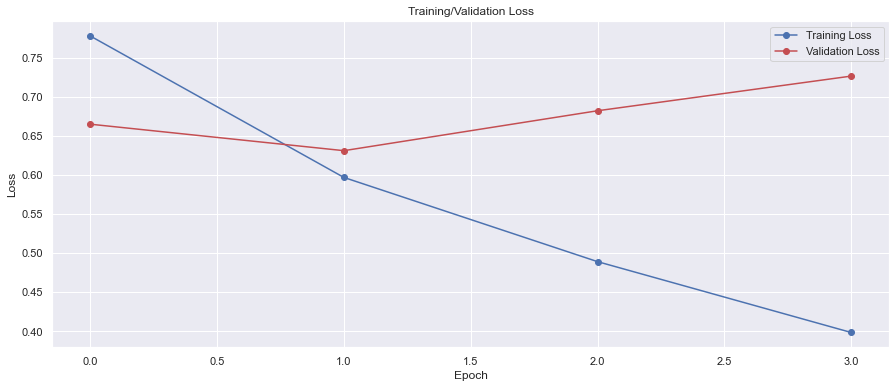

[2022-11-04 01:13:31,794][INFO] ## epoch: best, acc: 0.73670620, f1: 0.73828710, best_f1: 0.73828710



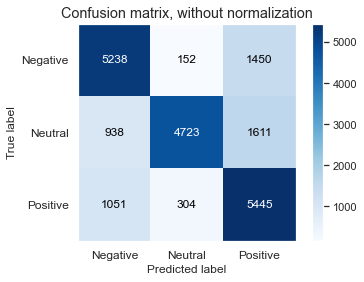

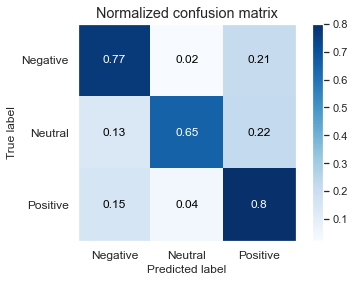

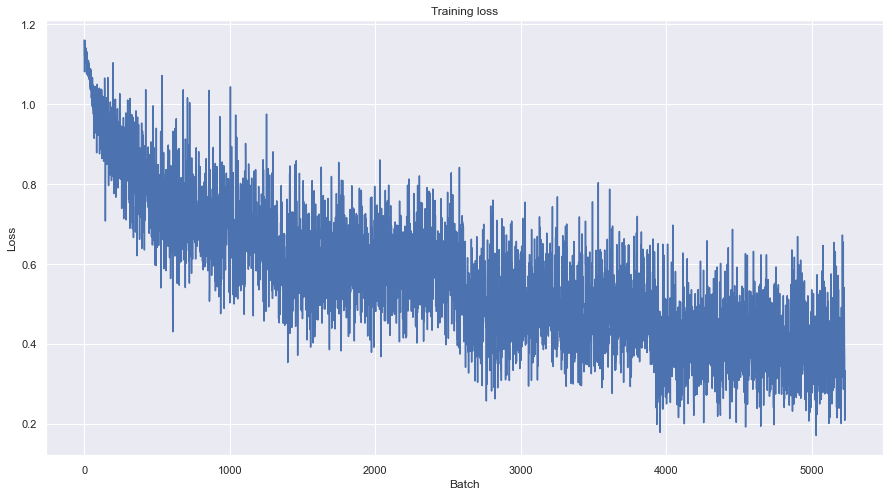

#################### FINAL RESULT ####################
Average Accuracy: 0.73670620, Average F1: 0.73828710


In [29]:
for n_fold, (train_indices, valid_indices) in enumerate(kfold.split(y_train, y_train)):
    #logger.info('================     fold {}    ==============='.format(n_fold+1))
    print('================     fold {}    ==============='.format(n_fold+1))
    # Input train data for this fold
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    # Input validation data for this fold
    x_valid_fold = x_train[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Make sure to load the pre-trained model every time
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    
    acc, f1, valid_best, _ = train_transformer(bert_model, x_train_fold, y_train_fold, x_valid_fold, y_valid_fold, learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    oof_train[valid_indices] = valid_best

    acc_list.append(acc)
    f1_list.append(f1)
    
    
    # Number of folds to iterrate
    if n_fold == 0:
        break

print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 9804 (1634 batches x 6 epochs)


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

[2022-11-04 08:20:30,923][DEBUG] ## train batch: 0, train_loss: 0.000693
[2022-11-04 08:20:31,642][DEBUG] ## train batch: 1, train_loss: 0.000663
[2022-11-04 08:20:32,404][DEBUG] ## train batch: 2, train_loss: 0.000684
[2022-11-04 08:20:33,167][DEBUG] ## train batch: 3, train_loss: 0.000683
[2022-11-04 08:20:33,961][DEBUG] ## train batch: 4, train_loss: 0.000682
[2022-11-04 08:20:34,737][DEBUG] ## train batch: 5, train_loss: 0.000685
[2022-11-04 08:20:35,481][DEBUG] ## train batch: 6, train_loss: 0.000675
[2022-11-04 08:20:36,270][DEBUG] ## train batch: 7, train_loss: 0.000661
[2022-11-04 08:20:37,013][DEBUG] ## train batch: 8, train_loss: 0.000701
[2022-11-04 08:20:37,744][DEBUG] ## train batch: 9, train_loss: 0.000654
[2022-11-04 08:20:38,478][DEBUG] ## train batch: 10, train_loss: 0.000648
[2022-11-04 08:20:39,232][DEBUG] ## train batch: 11, train_loss: 0.000678
[2022-11-04 08:20:39,988][DEBUG] ## train batch: 12, train_loss: 0.000676
[2022-11-04 08:20:40,736][DEBUG] ## train batch:

Epoch:  17%|█▋        | 1/6 [24:02<2:00:14, 1442.96s/it]

[2022-11-04 08:44:33,709][DEBUG] ## train batch: 0, train_loss: 0.000395
[2022-11-04 08:44:34,551][DEBUG] ## train batch: 1, train_loss: 0.000391
[2022-11-04 08:44:35,363][DEBUG] ## train batch: 2, train_loss: 0.000358
[2022-11-04 08:44:36,183][DEBUG] ## train batch: 3, train_loss: 0.000339
[2022-11-04 08:44:37,022][DEBUG] ## train batch: 4, train_loss: 0.000365
[2022-11-04 08:44:37,860][DEBUG] ## train batch: 5, train_loss: 0.000365
[2022-11-04 08:44:38,701][DEBUG] ## train batch: 6, train_loss: 0.000284
[2022-11-04 08:44:39,508][DEBUG] ## train batch: 7, train_loss: 0.000405
[2022-11-04 08:44:40,357][DEBUG] ## train batch: 8, train_loss: 0.000381
[2022-11-04 08:44:41,188][DEBUG] ## train batch: 9, train_loss: 0.000311
[2022-11-04 08:44:42,076][DEBUG] ## train batch: 10, train_loss: 0.000425
[2022-11-04 08:44:42,928][DEBUG] ## train batch: 11, train_loss: 0.000355
[2022-11-04 08:44:43,751][DEBUG] ## train batch: 12, train_loss: 0.000306
[2022-11-04 08:44:44,574][DEBUG] ## train batch:

Epoch:  33%|███▎      | 2/6 [48:50<1:37:57, 1469.44s/it]

[2022-11-04 09:09:21,676][DEBUG] ## train batch: 0, train_loss: 0.000300
[2022-11-04 09:09:22,495][DEBUG] ## train batch: 1, train_loss: 0.000322
[2022-11-04 09:09:23,298][DEBUG] ## train batch: 2, train_loss: 0.000319
[2022-11-04 09:09:24,146][DEBUG] ## train batch: 3, train_loss: 0.000323
[2022-11-04 09:09:24,989][DEBUG] ## train batch: 4, train_loss: 0.000207
[2022-11-04 09:09:25,810][DEBUG] ## train batch: 5, train_loss: 0.000375
[2022-11-04 09:09:26,659][DEBUG] ## train batch: 6, train_loss: 0.000273
[2022-11-04 09:09:27,480][DEBUG] ## train batch: 7, train_loss: 0.000267
[2022-11-04 09:09:28,311][DEBUG] ## train batch: 8, train_loss: 0.000307
[2022-11-04 09:09:29,159][DEBUG] ## train batch: 9, train_loss: 0.000290
[2022-11-04 09:09:29,987][DEBUG] ## train batch: 10, train_loss: 0.000252
[2022-11-04 09:09:30,819][DEBUG] ## train batch: 11, train_loss: 0.000332
[2022-11-04 09:09:31,640][DEBUG] ## train batch: 12, train_loss: 0.000339
[2022-11-04 09:09:32,478][DEBUG] ## train batch:

Epoch:  50%|█████     | 3/6 [1:13:39<1:13:54, 1478.26s/it]

[2022-11-04 09:34:10,464][DEBUG] ## train batch: 0, train_loss: 0.000177
[2022-11-04 09:34:11,289][DEBUG] ## train batch: 1, train_loss: 0.000287
[2022-11-04 09:34:12,096][DEBUG] ## train batch: 2, train_loss: 0.000262
[2022-11-04 09:34:12,939][DEBUG] ## train batch: 3, train_loss: 0.000188
[2022-11-04 09:34:13,762][DEBUG] ## train batch: 4, train_loss: 0.000217
[2022-11-04 09:34:14,588][DEBUG] ## train batch: 5, train_loss: 0.000255
[2022-11-04 09:34:15,408][DEBUG] ## train batch: 6, train_loss: 0.000188
[2022-11-04 09:34:16,254][DEBUG] ## train batch: 7, train_loss: 0.000302
[2022-11-04 09:34:17,067][DEBUG] ## train batch: 8, train_loss: 0.000201
[2022-11-04 09:34:17,882][DEBUG] ## train batch: 9, train_loss: 0.000253
[2022-11-04 09:34:18,711][DEBUG] ## train batch: 10, train_loss: 0.000186
[2022-11-04 09:34:19,524][DEBUG] ## train batch: 11, train_loss: 0.000233
[2022-11-04 09:34:20,350][DEBUG] ## train batch: 12, train_loss: 0.000216
[2022-11-04 09:34:21,176][DEBUG] ## train batch:

Epoch:  50%|█████     | 3/6 [1:38:31<1:38:31, 1970.35s/it]

================ Training Completed: Starting Post Process ===============


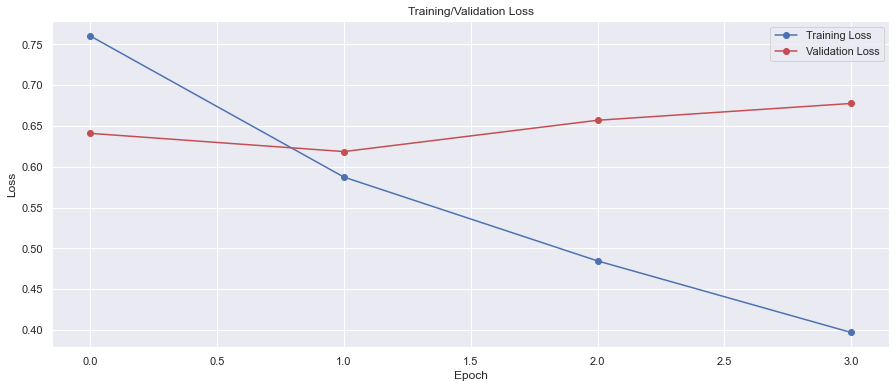

[2022-11-04 09:59:01,203][INFO] ## epoch: best, acc: 0.74417089, f1: 0.74468248, best_f1: 0.74468248



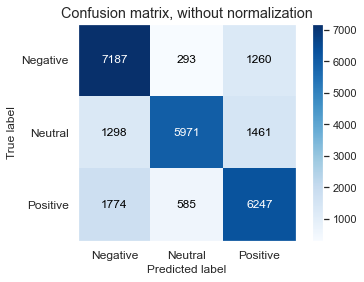

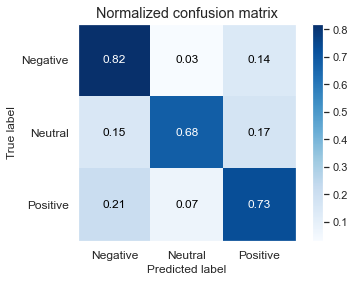

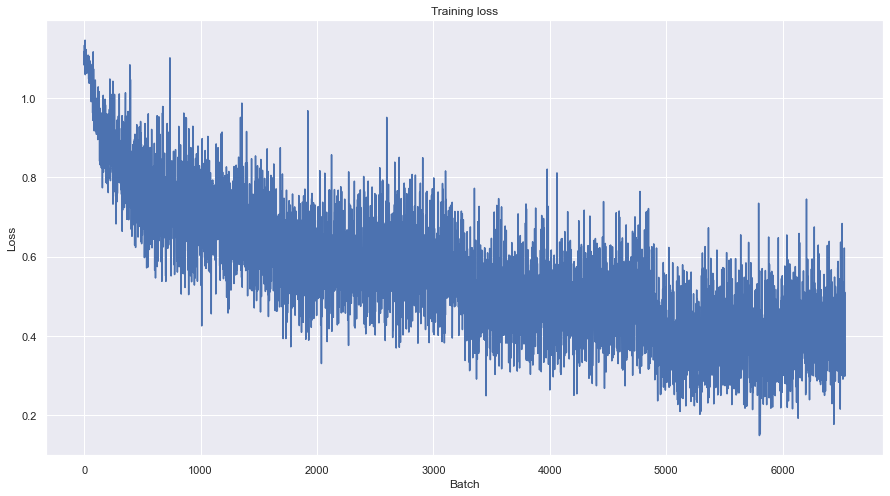

Accuracy: 0.74417089, f1: 0.74468248



In [30]:
# Re-train the model with all Train set and validate on Test set

# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
x_test = np.array(test['sentence'])
y_test = np.array(test['label'].astype(int).values)

# Make sure to load the pre-trained model every time
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

acc, f1, valid_best, model_trained = \
        train_transformer(bert_model, x_train, y_train, x_test, y_test, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    
print(('Accuracy: %.8f, f1: %.8f\n' % (acc, f1)))

output_dir = "Models/BERT/"
torch.save(model_trained.state_dict(), output_dir + 'fintweet_bert.dict')